In [1]:
import pandas as pd
import numpy as np
import openpyxl
import pandas_ta as ta
import sys
sys.path.append (r"C:\TheG\codes\codes")
import self_code as sc
import Utils as ut
import glob
import warnings
warnings.filterwarnings("ignore")

In [2]:
nifty_futures = pd.read_csv(r"D:\Data\Indian\Index\Futures\NIFTY-FUT1.csv")
nifty_spot = pd.read_csv(r"D:\Data\Indian\Index\Spot\NIFTY.csv")

In [3]:
nifty_futures = sc.resample(nifty_futures, '1h')
nifty_spot = sc.resample(nifty_spot, '1h')

In [4]:
# removing high low close
nifty_spot = nifty_spot[['open']]
nifty_futures = nifty_futures[['open']]
nifty_futures.rename(columns = {'open':'nifty futures'}, inplace = True)
nifty_spot.rename(columns = {'open':'nifty spot'}, inplace = True)

In [5]:
df = pd.merge(nifty_spot, nifty_futures, on = 'datetime', how = 'outer').dropna()

In [6]:
df['difference'] = df['nifty futures'] - df['nifty spot']

In [7]:
print(f'The maxima of the dataset is {df['difference'].max()}')
print(f'The minima of the dataset is {df['difference'].min()}')

The maxima of the dataset is 196.54999999999927
The minima of the dataset is -239.9499999999971


Assumption is spot shall follow futures

In [8]:
# that day function 
def option_simplify(df, row):
    df['datetime'] = df['Date'] + ' ' + df['Time']
    df['datetime'] = df['Date'] + ' ' + df['Time']
    df['datetime'] = pd.to_datetime(df['datetime']).dt.floor('min')
    df = df[df['datetime'] >= row]
    df = sc.resample(df, '1h')
    return df

In [33]:
pnl = pd.DataFrame(columns = ['Type', 'Entry Price', 'Entry Time', 'Exit Price', 'Exit Time', 'Points', 'Pnl'])
for i in ['11:15:00', '12:15:00']:
    for row, value in df.iterrows():
        try:
            if str(row.time()) == i:
                if sc.StrikePremiumSelector('NIFTY', value['nifty spot'], row, '>=', premium= abs(value['difference']), optionType='CE') == 0:
                    continue
                if sc.StrikePremiumSelector('NIFTY', value['nifty spot'], row, '>=', premium= abs(value['difference']), optionType='PE') == 0:
                    continue
                ce = sc.StrikePremiumSelector('NIFTY', value['nifty spot'], row, '>=', premium= abs(value['difference']), optionType='CE')
                ce_data = pd.read_csv(r"D:\Data\Indian\Index\Options\nifty options\{}.csv".format(ce))
                ce_data = option_simplify(ce_data, row)
                status = 0
                entry_price = 0
                entry_time = 0
                sl = 0
                for idx, val in ce_data.iterrows():
                    if status == 0:
                        status = 1
                        entry_price = val['Close']
                        if entry_price < 10:
                            break
                        entry_time = idx
                        sl = entry_price + value['difference']
                        continue
                    elif status == 1 and val['High'] >= sl >= val['Low']:
                        pnl.loc[len(pnl)] = [ce, entry_price, entry_time, sl, idx, (entry_price - sl), (entry_price - sl) * 50]
                        status = 0
                        break
                    elif status == 1 and str(idx.time()) == '15:15:00':
                        pnl.loc[len(pnl)] = [ce, entry_price, entry_time, val['Open'], idx, (entry_price - val['Open']), (entry_price - val['Open']) * 50]
                        status = 0
                        break
                if entry_price < 10:
                    continue
                pe = sc.StrikePremiumSelector('NIFTY', value['nifty spot'], row, '>=', premium= abs(value['difference']), optionType='PE')
                pe_data = pd.read_csv(r"D:\Data\Indian\Index\Options\nifty options\{}.csv".format(pe))
                pe_data = option_simplify(pe_data, row)
                status = 0
                entry_price = 0
                entry_time = 0
                sl = 0
                for idx, val in pe_data.iterrows():
                    if status == 0:
                        status = 1
                        entry_price = val['Close']
                        if entry_price < 10:
                            break
                        entry_time = idx
                        sl = entry_price + value['difference']
                        continue
                    elif status == 1 and val['High'] >= sl >= val['Low']:
                        pnl.loc[len(pnl)] = [pe, entry_price, entry_time, sl, idx, (entry_price - sl), (entry_price - sl) * 50]
                        status = 0
                        break
                    elif status == 1 and str(idx.time()) == '15:15:00':
                        pnl.loc[len(pnl)] = [pe, entry_price, entry_time, val['Open'], idx, (entry_price - val['Open']), (entry_price - val['Open']) * 50]
                        status = 0
                        break
        except Exception as e:
            print(e)
            continue
pnl = pnl.sort_values(by = 'Entry Time')

KeyboardInterrupt: 

<Axes: >

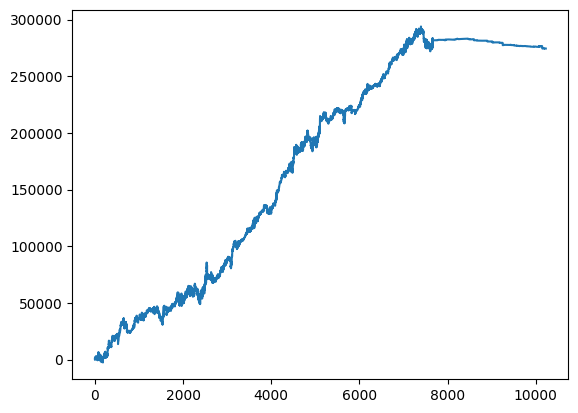

In [ ]:
pnl.Pnl.cumsum().plot()

In [29]:
pnl = pnl[pnl['Entry Time'].dt.time != pd.to_datetime('14:15:00').time()]

In [31]:
sc.final(pnl, r'C:\work\balysis\Self made\Footoore\result.xlsx', capital = 130000)